## 합성곱 신경망

- 이미지 전체를 한 번에 계산하는 것이 아닌, 이미지의 **국소적 부분**을 계산함

- 시간과 자원을 절약하고 이미지의 세밀한 부분까지 분석할 수 있음

#### 합성곱 연산의 필요성

- Fully Connected Layer의 경우,

- 2차원 데이터를 1차원으로 펼치고(flattening) 각 픽셀에 weight를 곱하여 전달하게 됨

  - *데이터의 공간적 구조를 무시하게 됨*

<img src="https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/73_blog_image_1.png" width="400px">

#### 합성곱 신경망 구조

- 입력층 - 합성곱층 - 풀링층 - 완전연결층 - 출력층

- 합성곱과 풀링 연산을 거치면서, 이미지의 특성 **feature vector**를 추출함

- 추출된 feature vector는 완전연결층을 거치며 1차원 vector로 변환됨

- 출력층에서 Softmax 함수를 거쳐 최종 결과를 출력함

<img src="https://production-media.paperswithcode.com/method_collections/cnn.jpeg" width="600px">

##### - 입력층

- 입력 이미지가 최초로 들어오는 레이어

- 이미지는 `(width, height, channel)`의 값을 갖는 3차원 데이터

##### - 합성곱층

- 입력 이미지에서 특성을 추출하는 레이어

- **kernel/filter**를 이용해 **stride** 간격만큼 순회하면서 합성곱 연산으로 **feature map**을 추출함

##### - 풀링층

- feature map을 다운 샘플링하는 레이어

- 연산량을 감소시키고, **주요한 특성**을 추출할 수 있음

- Max Pooling / Average Pooling

  - *Average Pooling : 커널 값을 평균화시켜, 중요한 가중치를 갖는 값의 특성이 희미해질 수 있음*

##### - 완전연결층

- feature map을 1차원 vector로 펼치는 레이어

##### - 출력층

- Softmax 함수를 통해 값을 0~1 사이의 값으로 출력함

- 각 레이블에 속할 확률값이 출력되며, 가장 높은 확률의 레이블이 최종 값으로 선정됨

---

#### * 1x1 Convolution

- 입력 `(W, H, C)`에 필터 `(1, 1, C)`를 적용하면, 출력은 `(W, H)`가 됨

  - 입력 이미지 사이즈 : (5x5x3)

  - 필터 사이즈 : (1x1x3)
  
    -> 출력 이미지 사이즈 : (5x5)
  
- feature map의 채널 수를 줄임으로써 **연산량을 감소**시키는 효과

- **feature map 간의 weighted sum**
  
  - `w1`x`F1` + `w2`x`F2` + `w3`x`F3`

    -> 어떤 feature map이 중요한 지 학습시켜서 더 나은 feature map을 얻게 하는 방법

  - https://youtu.be/WdA54S9yON8?list=PL_iJu012NOxdt7VSZK0sE2YvltT7NOlHH (13:03)

---

## 실습 : DNN vs CNN

#### 데이터셋 정보 : fashion_mnist dataset

- torchvision에 내장된 예제 데이터

- 이미지 : (28x28) 70,000장

- 레이블 : 0~9 정수 값

#### (1) 라이브러리 설치

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### (2) 데이터셋 준비

- 데이터셋 다운로드

  - Fashion MNIST 데이터셋을 내려받을 위치 설정
  
  - 이미지를 Tensor로 변환

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('./data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

- 데이터를 메모리로 불러오기

  - 내려받은 데이터셋을 `DataLoader`에 전달
  
    -> 원하는 batch size로 데이터를 불러오고, shuffle 가능

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

- 레이블 정의

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

- 이미지 데이터 확인

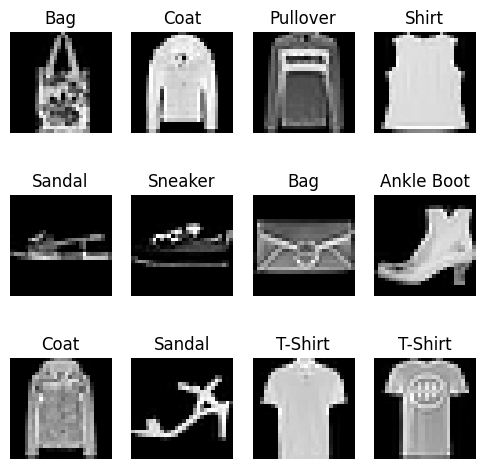

In [ ]:
fig = plt.figure(figsize=(6, 6))

columns = 4
rows = 3

for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)

    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

#### (3) 모델 비교

##### 심층 신경망(DNN)

- 모델 생성

In [ ]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256) # 첫 번째 FC Layer : 784->256
        self.dropout = nn.Dropout(0.25) # Dropout
        self.fc2 = nn.Linear(in_features=256, out_features=128) # 두 번째 FC Layer : 256->128
        self.fc3 = nn.Linear(in_features=128, out_features=10) # 세 번째 FC Layer : 128->10

    def forward(self, input_data):
        out = input_data.view(-1, 784) # 이미지 데이터 flatten -> (?, 784)로 변환
        out = torch.nn.functional.relu(self.fc1(out)) # FC Layer -> 활성화 함수
        out = self.dropout(out) # Dropout
        out = torch.nn.functional.relu(self.fc2(out)) # FC Layer -> 활성화 함수
        out = self.fc3(out) # FC Layer
        return out

In [ ]:
model = DNN()
model.to(device)
model

DNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

- 파라미터 정의

In [ ]:
learning_rate = 0.001 # 학습률
criterion = nn.CrossEntropyLoss() # 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 옵티마이저

- 모델 학습 및 평가

In [ ]:
epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # 모델과 데이터가 동일한 장치에 있어야 함

        # torch.autograd - Variable : 역전파를 위한 '미분 값'을 자동으로 계산함
        train = Variable(images.view(100, 1, 28, 28)) # (이미지 100개 사용, 채널 1, 높이 28, 너비 28)
        labels = Variable(labels)

        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels) # 손실함수 계산

        optimizer.zero_grad() # gradient 초기화
        loss.backward()
        optimizer.step() # gradient 업데이트
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)

                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}")

Iteration: 500, Loss: 0.6025778651237488, Accuracy: 82.95999908447266
Iteration: 1000, Loss: 0.497733473777771, Accuracy: 84.5
Iteration: 1500, Loss: 0.4233851730823517, Accuracy: 83.77999877929688
Iteration: 2000, Loss: 0.3933137059211731, Accuracy: 85.29999542236328
Iteration: 2500, Loss: 0.3127569854259491, Accuracy: 86.32999420166016
Iteration: 3000, Loss: 0.29740265011787415, Accuracy: 86.68999481201172


- 정확도 86%

#### 합성곱 신경망(CNN)

- 모델 생성

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 입력 채널 : 흑백 -> 1 / RGB -> 3
            nn.BatchNorm2d(32), # 각 배치마다 데이터 분포가 다른 것을 정규화 함 -> 가우시안 분포(평균 0, 표준편차 1로 조정)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.dropout = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # FC Layer에서 처리하기 위해, 각 이미지 별로 1차원 vector로 변환
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
model = CNN()
model.to(device)
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

---

##### *데이터 사이즈 확인*

- 출력 크기 계산 : `(W - F + 2P) / S + 1`

- 입력 데이터 : (28x28x1) 흑백 이미지

- Conv layer 1 :
    - Convolution : (28 - 3 + 2) / 1 + 1 = 28 -> (28x28)x32

    - Pooling : 28 / 2 = 14 -> **(14x14)x32**
<br><br>
- Conv layer 2 :

    - Convolution : (14 - 3 + 0) / 1 + 1 = 12 -> (12x12)x64

    - Pooling : 12 / 2 = 6 -> **(6x6)x64**
<br><br>
- Flattening

    - 6x6x64 -> **100x2304**

In [ ]:
# batch_size = 100으로 설정 했으므로 이미지는 100개 / 채널 64 / 높이 6 / 너비 6
example = torch.randn(100, 64, 6, 6) # (순서 주의)
example.size()

torch.Size([100, 64, 6, 6])

In [ ]:
# FC Layer 처리를 위해, 각 이미지를 1차원 vector로 변환
example = example.view(example.size(0), -1)
example.size()

torch.Size([100, 2304])

- FC layer 1 :

    - 2304 -> **600**
<br><br>  
- FC layer 2 :

    - 600 -> **120**
<br><br>
- FC layer 3 :

    - 120 -> **10** (레이블 개수)

---

- 파라미터 정의

In [ ]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

- 모델 학습 및 평가

In [ ]:
epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)

                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4507959485054016, Accuracy: 88.22000122070312
Iteration: 1000, Loss: 0.30736473202705383, Accuracy: 88.44999694824219
Iteration: 1500, Loss: 0.3723900318145752, Accuracy: 87.40999603271484
Iteration: 2000, Loss: 0.2071247547864914, Accuracy: 88.38999938964844
Iteration: 2500, Loss: 0.14476114511489868, Accuracy: 89.66999816894531
Iteration: 3000, Loss: 0.15411515533924103, Accuracy: 90.4000015258789


- 정확도 90%